### Import Library dan Dataset

In [1]:
import os
import gc
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"
os.environ["HF_HUB_OFFLINE"] = "1"

In [2]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

I0000 00:00:1768723986.056056   86026 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1768723986.154645   86026 cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1768723987.160027   86026 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/sorr/anaconda3/envs/nightly_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProg

In [3]:
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
LOCAL_DIR = "../local-xlmr-tf"
BATCH_SIZE = 16
LR = 2e-5
MAX_LEN = 128
EPOCHS = 1

In [5]:
# GPU memory growth (safe for tf-nightly)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except Exception as e:
            print("Warning: set_memory_growth failed:", e)

# Mixed precision (optional, often supported in tf-nightly)
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled:", mixed_precision.global_policy())
except Exception as e:
    print("Mixed precision unavailable or failed:", e)

# helper to free memory between trials/folds


def free_mem():
    try:
        tf.keras.backend.clear_session()
    except Exception:
        pass
    gc.collect()


print("TensorFlow version:", tf.__version__)
print("Num GPUs:", len(gpus))

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 5070, compute capability 12.0
Mixed precision enabled: <Policy "mixed_float16">
TensorFlow version: 2.21.0-dev20251013
Num GPUs: 1


W0000 00:00:1768723988.952649   86026 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.


In [6]:
df = pd.read_csv('../data/data_cleaned.csv')
df.head()

,Tweet,Label
0,saya takut kehilangan hal kecil,Takut
1,tidak ada cahaya buat dituju,Sedih
2,rasanya like semuanya sinkron,Gembira
3,yaallah mika angkasa saya kaget saya kira cuma...,Takut
4,saya cemas sejak tadi pagi,Takut


### Persiapan Dataset

In [7]:
le = LabelEncoder()
df['LabelEncoded'] = le.fit_transform(df['Label'])
label_names = le.classes_.tolist()
num_labels = len(label_names)

print(f"Total samples: {len(df)}")
print(f"Number of labels: {num_labels}")
print(f"Label mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Total samples: 10075
Number of labels: 5
Label mapping: {'Cinta': np.int64(0), 'Gembira': np.int64(1), 'Marah': np.int64(2), 'Sedih': np.int64(3), 'Takut': np.int64(4)}


In [8]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["Tweet"].tolist(),
    df["LabelEncoded"].tolist(),
    test_size=0.30,  # 30% = 3000 samples untuk val + test
    stratify=df["LabelEncoded"],
    random_state=SEED
)

# Split temp menjadi val dan test
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, 
    temp_labels,
    test_size=0.50,  # 15% dari total = 1500 samples untuk test
    stratify=temp_labels,
    random_state=SEED
)

print(f"Train: {len(train_texts):,} samples")
print(f"Val: {len(val_texts):,} samples")
print(f"Test: {len(test_texts):,} samples (UNTOUCHED)")

Train: 7,052 samples
Val: 1,511 samples
Test: 1,512 samples (UNTOUCHED)


### Tokenisasi

In [9]:
tokenizer = AutoTokenizer.from_pretrained(LOCAL_DIR)

def tokenize_texts(texts, max_len=MAX_LEN):
    return tokenizer(
        texts,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    
train_encodings = tokenize_texts(train_texts)
val_encodings = tokenize_texts(val_texts)
test_encodings = tokenize_texts(test_texts)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
W0000 00:00:1768723989.956836   86026 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1768723990.077082   86026 gpu_device.cc:2040] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9129 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5070, pci bus id: 0000:01:00.0, compute capability: 12.0a


In [10]:
# Batching dataset
def create_tf_dataset(encodings, labels, batch_size=BATCH_SIZE, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        labels
    ))
    
    if shuffle:
        dataset = dataset.shuffle(1000)
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_dataset = create_tf_dataset(train_encodings, train_labels, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = create_tf_dataset(val_encodings, val_labels, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = create_tf_dataset(test_encodings, test_labels, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
experiment_model = TFAutoModelForSequenceClassification.from_pretrained(
    LOCAL_DIR,
    num_labels=num_labels,
    local_files_only=True
)

experiment_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFXLMRobertaForSequenceClassification.

All the layers of TFXLMRobertaForSequenceClassification were initialized from the model checkpoint at ../local-xlmr-tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForSequenceClassification for predictions without further training.


In [12]:
history_final = experiment_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=1
)

E0000 00:00:1768724016.366225   86026 util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1768724018.219964   86295 service.cc:158] XLA service 0x7d5f63ea6700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768724018.220005   86295 service.cc:166]   StreamExecutor device (0): NVIDIA GeForce RTX 5070, Compute Capability 12.0a
I0000 00:00:1768724018.241133   86296 dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1768724018.265920   86295 cuda_dnn.cc:463] Loaded cuDNN version 91400
I0000 00:00:1768724018.363941   86295 device_compiler.h:208] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


441/441 [==============================] - 109s 201ms/step - loss: 1.2347 - accuracy: 0.5067 - val_loss: 0.5695 - val_accuracy: 0.8220


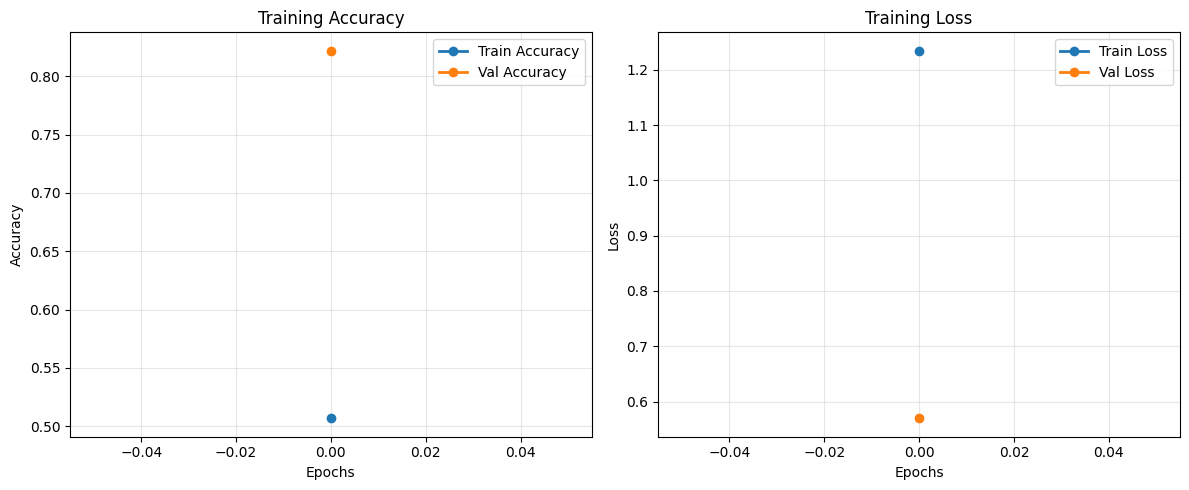

In [13]:
# Plot 4: Training History Final Model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_final.history['accuracy'],
         label='Train Accuracy', marker='o', linewidth=2)
plt.plot(history_final.history['val_accuracy'],
         label='Val Accuracy', marker='o', linewidth=2)
plt.title(f'Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_final.history['loss'], label='Train Loss',
         marker='o', linewidth=2)
plt.plot(history_final.history['val_loss'], label='Val Loss',
         marker='o', linewidth=2)
plt.title(f'Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
experiment_loss, experiment_accuracy = experiment_model.evaluate(test_dataset, verbose=0)
    
print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print(f"Test Loss: {experiment_loss:.4f}")
print(f"Test Accuracy: {experiment_accuracy:.4f}")
print(f"Epochs Used: 10")


FINAL RESULTS
Test Loss: 0.5512
Test Accuracy: 0.8300
Epochs Used: 10


### Inferensi Model

In [15]:
XLMR_MODEL_PATH = "./XLMR_Model"
inference_tokenizer = AutoTokenizer.from_pretrained(XLMR_MODEL_PATH)

In [16]:
EXTERNAL_TEST_PATH = "../data/external_test.csv"


# Load external dataset
external_df = pd.read_csv(EXTERNAL_TEST_PATH)

# Cek struktur dataset
print(f"External dataset shape: {external_df.shape}")
print(f"Columns: {external_df.columns.tolist()}")
print(f"\n First few rows:")
print(external_df.head())

print(f"\nClass distribution in external data:")
print(external_df['Label'].value_counts())

External dataset shape: (1932, 2)
Columns: ['Label', 'Tweet']

 First few rows:
   Label                                          Tweet
0  Cinta          rasanya mirip hati saya disusun ulang
1  Cinta      rasanya mirip saya diselimuti rasa sayang
2  Cinta  rasanya mirip hati saya ditempel spark lembut
3  Cinta           saya suka tiap dia bilang saya cukup
4  Cinta           saya suka tiap dia ngulang kata saya

Class distribution in external data:
Label
Gembira    695
Sedih      580
Marah      275
Takut      223
Cinta      159
Name: count, dtype: int64


In [17]:
# Cek label yang ada di external data
external_labels = external_df['Label'].unique()
print(f"Unique labels in external data: {external_labels}")

Unique labels in external data: ['Cinta' 'Gembira' 'Marah' 'Sedih' 'Takut']


In [18]:
le.fit(label_names)  # Fit dengan label names yang konsisten

external_df['LabelEncoded'] = le.transform(external_df['Label'])
print(f"Final external dataset: {len(external_df)} samples")

Final external dataset: 1932 samples


In [19]:
# Tokenisasi external data
external_texts = external_df['Tweet'].tolist()
external_true_labels = external_df['LabelEncoded'].tolist()

def inference_tokenize_texts(texts, max_len=MAX_LEN):
    return inference_tokenizer(
        texts,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

external_encodings = inference_tokenize_texts(external_texts)

# Buat dataset
external_dataset = tf.data.Dataset.from_tensor_slices((
    dict(external_encodings),
    tf.convert_to_tensor(external_true_labels)
)).batch(16).prefetch(tf.data.AUTOTUNE)

In [20]:
# Evaluate model
experimental_external_loss, experimental_external_accuracy = experiment_model.evaluate(
    external_dataset, verbose=0)

print("\n" + "="*60)
print("EXTERNAL TEST RESULTS - GENERALIZATION PERFORMANCE")
print("="*60)
print(f"External Test Loss: {experimental_external_loss:.4f}")
print(f"External Test Accuracy: {experimental_external_accuracy:.4f}")
print(f"Number of samples: {len(external_df)}")


EXTERNAL TEST RESULTS - GENERALIZATION PERFORMANCE
External Test Loss: 0.6126
External Test Accuracy: 0.7961
Number of samples: 1932
